# Model 2 Training Environment

This notebook contains the training environnment for the second iteration of the signature verification siamese network model. The main issue with model 1 that model 2  adressed was an inability to achieve any level of convergence. Model 2 was able to achieve a small amount of convergence, reaching aprox 25% accuracy during training eval. This is better than the 0% Model 1 conistently achieved, though not great. 

This increase in accuracy and convergence was achieved by simplifying the data preperation process and the way the model intakes data. I experimented with various hyperparameters to improve performance but the model alwasy plateaus around the 25% val acc range. It's not clear why this is happening. 

My guess is that the increase in complexity of the task from mnist to signature data has increased the difficult of the learning problem such that training the model from randomly initialized weights is not particularly practical. For model iteration 3 I will us transfer learning in the encoder to try and reduced the barrier to entry for the model to improve at the task.

### Here I am going to load in the dataset that was processed within data_wrangling_model_2.ipynb

In [ ]:
import torch

# load test_images.py test_labels.py train_images.py train_labels.py from cwd

test_images = torch.load('test_images.pt')
test_labels = torch.load('test_labels.pt')
train_images = torch.load('train_images.pt')
train_labels = torch.load('train_labels.pt')

In [4]:
print(f'test_images: {test_images.shape}')
print(f'test_labels: {test_labels.shape}\n')
print(f'train_images: {train_images.shape}')
print(f'train_labels: {train_labels.shape}')

test_images: torch.Size([252, 3, 224, 224])
test_labels: torch.Size([252])

train_images: torch.Size([887, 3, 224, 224])
train_labels: torch.Size([887])


### Load in Model

This is the adjusted model for the mnist

In [4]:
from model_2 import SiameseNet 

model = SiameseNet(input_shape = (1, 3, 224, 224),
                   embedding_size = 10,
                  initial_channel_increase = 16)

block 1: 16
block 2: 32
block 3: 64
block 4: 128
block 5: 256


Below I am running a forward pass on a single example

In [5]:
print(f'test_images: {test_images.shape}')
print(f'test_labels: {test_labels.shape}\n')
print(f'train_images: {train_images.shape}')
print(f'train_labels: {train_labels.shape}')

test_images: torch.Size([252, 3, 224, 224])
test_labels: torch.Size([252])

train_images: torch.Size([887, 3, 224, 224])
train_labels: torch.Size([887])


Here I am running a forward pass to check the model works before starting training.

In [6]:
# extract two images
image_1 = train_images[0].unsqueeze(0)
image_2 = train_images[1].unsqueeze(0)

print(f'Image 1: {image_1.shape}')
print(f'Image 2: {image_2.shape}')

# extract two labels
label_1 = train_labels[0]
label_2 = train_labels[1]

# create target based on their similarity
target = [label_1 == label_2][0].float()

print(target)

# send model and images to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
image_1 = image_1.to(device)
image_2 = image_2.to(device)

# forward pass
output = model(image_1, image_2)

print(f'output: {output.shape}')
print(f'output: {output}')

# compute prediction
prediction = torch.ge(output, 0.5).item()

print(f'prediction: {prediction} ----- target: {target}')


Image 1: torch.Size([1, 3, 224, 224])
Image 2: torch.Size([1, 3, 224, 224])
tensor(1.)
output: torch.Size([1])
output: tensor([0.6892], device='cuda:0', grad_fn=<SigmoidBackward0>)
prediction: True ----- target: 1.0


In [7]:
# Count the number of trainable parameters
layer_params = [p.numel() for p in model.parameters() if p.requires_grad]

# print params at each layer
for i, p in enumerate(layer_params):
    print(f"Layer {i} has {p} parameters")

# sum parameters
print(f"\n Total number of trainable parameters: {sum(layer_params)}")

Layer 0 has 432 parameters
Layer 1 has 16 parameters
Layer 2 has 16 parameters
Layer 3 has 16 parameters
Layer 4 has 2304 parameters
Layer 5 has 16 parameters
Layer 6 has 16 parameters
Layer 7 has 16 parameters
Layer 8 has 4608 parameters
Layer 9 has 32 parameters
Layer 10 has 32 parameters
Layer 11 has 32 parameters
Layer 12 has 9216 parameters
Layer 13 has 32 parameters
Layer 14 has 32 parameters
Layer 15 has 32 parameters
Layer 16 has 18432 parameters
Layer 17 has 64 parameters
Layer 18 has 64 parameters
Layer 19 has 64 parameters
Layer 20 has 36864 parameters
Layer 21 has 64 parameters
Layer 22 has 64 parameters
Layer 23 has 64 parameters
Layer 24 has 73728 parameters
Layer 25 has 128 parameters
Layer 26 has 128 parameters
Layer 27 has 128 parameters
Layer 28 has 147456 parameters
Layer 29 has 128 parameters
Layer 30 has 128 parameters
Layer 31 has 128 parameters
Layer 32 has 294912 parameters
Layer 33 has 256 parameters
Layer 34 has 256 parameters
Layer 35 has 256 parameters
Layer

## Convert Data to Tensor Datasets and Wrap in Dataloader

In [8]:
from torch.utils.data import DataLoader, TensorDataset

# create train and test datasets
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

# create train and test dataloaders
trainloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
testloader = DataLoader(test_dataset, batch_size = 32, shuffle = True)

## Load Training Environment

Here, I am setting up the Trainer class. I've set the epochs to 1000 and also turned off early stopping to gather an overabundance of data for the learning curves.

In [9]:
from train import Trainer
import torch.nn as nn

#set criterion and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #weight_decay=0.001)

#set epochs
epochs = 1000

#set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

#set early stopping patience
patience = 2000

# create trainer instance
trainer = Trainer( model = model,
                   criterion = criterion, 
                   optimizer = optimizer, 
                   train_loader = trainloader, 
                   val_loader = testloader, 
                   epochs = epochs, 
                   device = device, 
                   early_stopping_patience = patience, 
                   batch_size=64)

Device: cuda


In [10]:
print(len(trainloader))
print(len(testloader))

28
8


Here I'm running the Trainer. I've saved the epoch log printout to training_log.txt

In [ ]:
import time

print("starting training...\n\n")

start = time.time()

best_model, val_loss, val_acc, train_loss, train_acc = trainer.train()    

end = time.time()

print(f"\nTraining time: {end - start}")

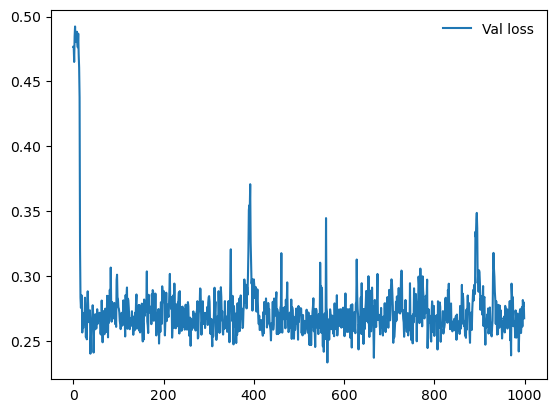

In [14]:
import matplotlib.pyplot as plt

#plot python lists historical_loss and historical_acc
plt.plot(val_loss, label='Val loss')
#plt.plot(train_loss, label="Train loss")
plt.legend(frameon=False)


These plots show, although training did not go well, that the model and training method now have the capacity to learn/converge. 

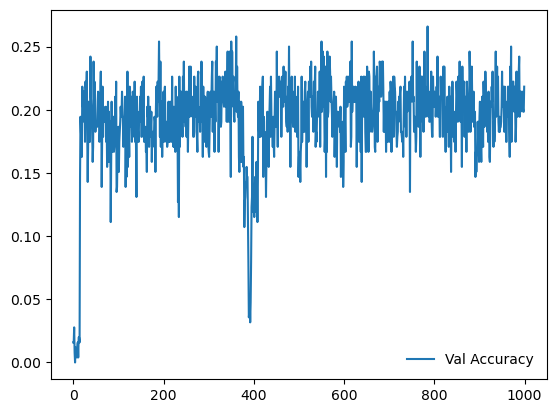

In [15]:
import matplotlib.pyplot as plt

#plot python lists historical_loss and historical_acc
plt.plot(val_acc, label='Val Accuracy')
#plt.plot(train_acc, label="Train Accuracy")
plt.legend(frameon=False)

In [ ]:
torch.save(best_model, "model_2_1.pth")